In [1]:
!pwd
%cd drive/MyDrive/nlp100/chapter09

/content
/content/drive/MyDrive/nlp100/chapter09


In [2]:
# knock50

import pandas as pd
from sklearn.model_selection import train_test_split
# FORMAT: ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP
df = pd.read_csv("newsCorpora.csv", sep="\t", header=None, names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

# 該当するpublisherの記事を抽出する
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df = df[df['PUBLISHER'].isin(publishers)]
# TITLEとCATEGORYのみ抽出
df = df[["TITLE", "CATEGORY"]]

#データを分割しシャッフルする
train, test = train_test_split(df, test_size=0.2, shuffle=True)
test, valid = train_test_split(test, test_size=0.5, shuffle=True)

#ファイルに保存する
train.to_csv("train.txt", sep="\t", index=False, header=None)
valid.to_csv("valid.txt", sep="\t", index=False, header=None)
test.to_csv("test.txt", sep="\t", index=False, header=None)

print("train\n", train["CATEGORY"].value_counts())
print("valid\n", valid["CATEGORY"].value_counts())
print("test\n", test["CATEGORY"].value_counts())

train
 b    4466
e    4225
t    1236
m     745
Name: CATEGORY, dtype: int64
valid
 b    578
e    527
t    138
m     91
Name: CATEGORY, dtype: int64
test
 b    583
e    527
t    150
m     74
Name: CATEGORY, dtype: int64


In [3]:
# knock80
from collections import defaultdict
import string

# 頻度を数える
d = defaultdict(int) # 初期値を0にする
table = str.maketrans(string.punctuation, ' '*len(string.punctuation)) # 記号をスペースに置換する変換を記述
for text in train['TITLE']:
  for word in text.translate(table).split(): # スペースに変換する操作を実行し、区切って単語を格納。単語を一つ一つ見ていく
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True) # ソートする

# ID辞書を作成
id_dict = {word : i+1 for i, (word, cnt) in enumerate(d) if cnt > 1} # 出現頻度が高い順にidを振っていく

def tokenizer(text, id_dict=id_dict, unk=0):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [id_dict.get(word, unk) for word in text.translate(table).split()] # .get()を使うことで、keyに値が存在しない場合もエラーが出ず、初期値(0に設定してある)を取得する

text = train.iloc[1, train.columns.get_loc('TITLE')]
print(text)
print(tokenizer(text))

The new Bank boss with your financial fate in her hands: Deputy Governor is  ...
[9, 45, 98, 3023, 23, 564, 2318, 4204, 3, 47, 3532, 3533, 3024, 38]


In [4]:
print(train['TITLE'])

332589    Former male model Michael Egan drops third sex...
21378     The new Bank boss with your financial fate in ...
387476    Microsoft Eliminating 18000 Jobs as Nadella St...
34500     How do humans smell? Better than expected (or ...
301929             Fed Cuts Stimulus By Another $10 Billion
                                ...                        
7056      Lena Dunham May Leave Acting After HBO's 'Girl...
415114    MTV VMAs Will Air Ferguson Public Service Anno...
319900    Back to the Eighties! Demi Lovato is a blast f...
421019      BLOGS OF THE DAY: Bond Brosnan is back as a spy
405861     Exxon Bets on Russia as Rivals Stick to US Wells
Name: TITLE, Length: 10672, dtype: object


In [5]:
# knock81
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # ゼロベクトルを作成
    emb = self.emb(x)
    out, hidden = self.rnn(emb, hidden)
    out = self.fc(out[:, -1, :])
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
    return hidden

from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X.values[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

# パラメータの設定
VOCAB_SIZE = len(set(id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2683, 0.2821, 0.3346, 0.1150]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2054, 0.2248, 0.3751, 0.1947]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1433, 0.3323, 0.2835, 0.2410]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2371, 0.2089, 0.3202, 0.2338]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3242, 0.1434, 0.2903, 0.2421]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2281, 0.3168, 0.2683, 0.1868]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2488, 0.3107, 0.2774, 0.1631]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3145, 0.2298, 0.2997, 0.1560]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1400, 0.1838, 0.3253, 0.3510]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2406, 0.2011, 0.1718, 0.3866]], grad_fn=<SoftmaxBackward0>)


In [6]:
# knock82

from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  # 損失と正解率を計算
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  # モデルの学習を実行し、損失・正解率のログを返す
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播、誤差逆伝播、重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])


    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time()
    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

# パラメータの設定
VOCAB_SIZE = len(set(id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 0.003
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 0.9010, accuracy_train: 0.6640, loss_valid: 0.9509, accuracy_valid: 0.6417, 45.1432sec
epoch: 2, loss_train: 0.6866, accuracy_train: 0.7576, loss_valid: 0.8046, accuracy_valid: 0.7121, 45.9538sec
epoch: 3, loss_train: 0.5507, accuracy_train: 0.8006, loss_valid: 0.7228, accuracy_valid: 0.7459, 42.5057sec
epoch: 4, loss_train: 0.4459, accuracy_train: 0.8326, loss_valid: 0.6886, accuracy_valid: 0.7609, 43.0849sec
epoch: 5, loss_train: 0.3668, accuracy_train: 0.8649, loss_valid: 0.6729, accuracy_valid: 0.7714, 54.3098sec
epoch: 6, loss_train: 0.3118, accuracy_train: 0.8840, loss_valid: 0.6891, accuracy_valid: 0.7721, 44.3915sec
epoch: 7, loss_train: 0.2401, accuracy_train: 0.9229, loss_valid: 0.6534, accuracy_valid: 0.7699, 50.3508sec
epoch: 8, loss_train: 0.2021, accuracy_train: 0.9342, loss_valid: 0.6502, accuracy_valid: 0.7894, 52.2924sec
epoch: 9, loss_train: 0.1830, accuracy_train: 0.9441, loss_valid: 0.6602, accuracy_valid: 0.7916, 51.2473sec
epoch: 10, loss_tra

epoch: 1, loss_train: 1.2482, accuracy_train: 0.4290, loss_valid: 1.2605, accuracy_valid: 0.4318, 13.0947sec
epoch: 2, loss_train: 1.1564, accuracy_train: 0.5136, loss_valid: 1.1675, accuracy_valid: 0.5060, 10.7742sec
epoch: 3, loss_train: 1.1082, accuracy_train: 0.5692, loss_valid: 1.1174, accuracy_valid: 0.5735, 9.6160sec
epoch: 4, loss_train: 1.0599, accuracy_train: 0.6160, loss_valid: 1.0873, accuracy_valid: 0.6102, 9.2043sec
epoch: 5, loss_train: 1.0732, accuracy_train: 0.5935, loss_valid: 1.0820, accuracy_valid: 0.6064, 13.2905sec
epoch: 6, loss_train: 1.0977, accuracy_train: 0.5676, loss_valid: 1.1264, accuracy_valid: 0.5607, 14.5244sec
epoch: 7, loss_train: 1.0954, accuracy_train: 0.5647, loss_valid: 1.1313, accuracy_valid: 0.5420, 9.7286sec
epoch: 8, loss_train: 1.0653, accuracy_train: 0.5994, loss_valid: 1.1201, accuracy_valid: 0.5675, 11.5753sec
epoch: 9, loss_train: 1.0619, accuracy_train: 0.6007, loss_valid: 1.1088, accuracy_valid: 0.5795, 13.7589sec
epoch: 10, loss_train:

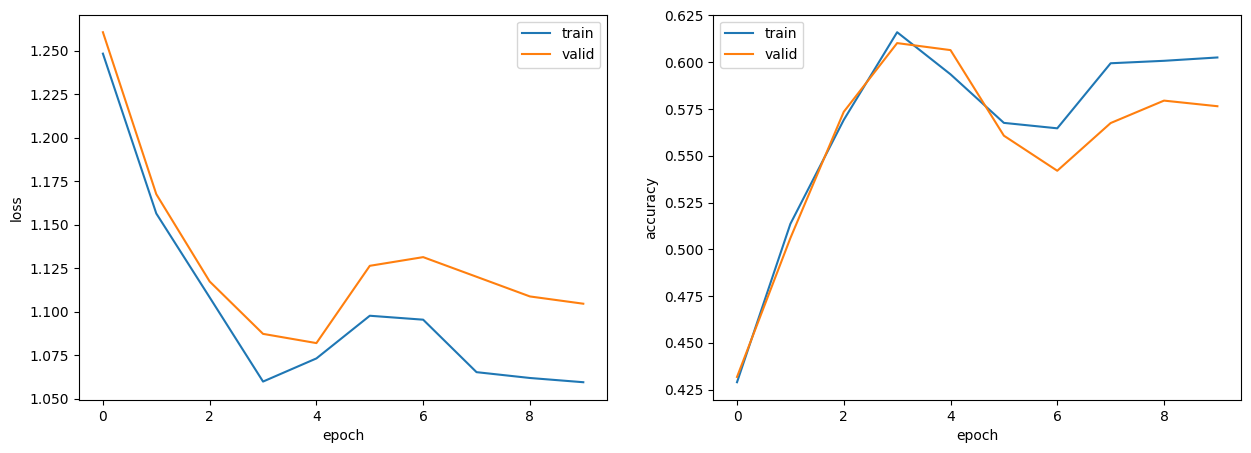

正解率（学習データ）：0.6025112443778111
正解率（評価データ）：0.5892053973013494


In [7]:
# knock83

class Padsequence():
  # 最大系列長に合わせる
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])
    return {'inputs': sequences_padded, 'labels': labels}

# パラメータの設定
VOCAB_SIZE = len(set(id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 0.05
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train}')
print(f'正解率（評価データ）：{acc_test}')

epoch: 1, loss_train: 1.1780, accuracy_train: 0.4084, loss_valid: 1.1693, accuracy_valid: 0.4048, 9.3840sec
epoch: 2, loss_train: 1.2409, accuracy_train: 0.3967, loss_valid: 1.2560, accuracy_valid: 0.3951, 9.7098sec
epoch: 3, loss_train: 1.0938, accuracy_train: 0.5493, loss_valid: 1.0919, accuracy_valid: 0.5465, 13.3212sec
epoch: 4, loss_train: 1.0958, accuracy_train: 0.5600, loss_valid: 1.0986, accuracy_valid: 0.5495, 10.6125sec
epoch: 5, loss_train: 1.0148, accuracy_train: 0.6190, loss_valid: 1.0237, accuracy_valid: 0.6207, 9.4256sec
epoch: 6, loss_train: 1.0207, accuracy_train: 0.6101, loss_valid: 1.0475, accuracy_valid: 0.6042, 9.1192sec
epoch: 7, loss_train: 1.0057, accuracy_train: 0.6165, loss_valid: 1.0360, accuracy_valid: 0.6049, 10.2320sec
epoch: 8, loss_train: 1.0329, accuracy_train: 0.6007, loss_valid: 1.0716, accuracy_valid: 0.5952, 10.9209sec
epoch: 9, loss_train: 0.9477, accuracy_train: 0.6406, loss_valid: 0.9686, accuracy_valid: 0.6274, 10.9684sec
epoch: 10, loss_train: 

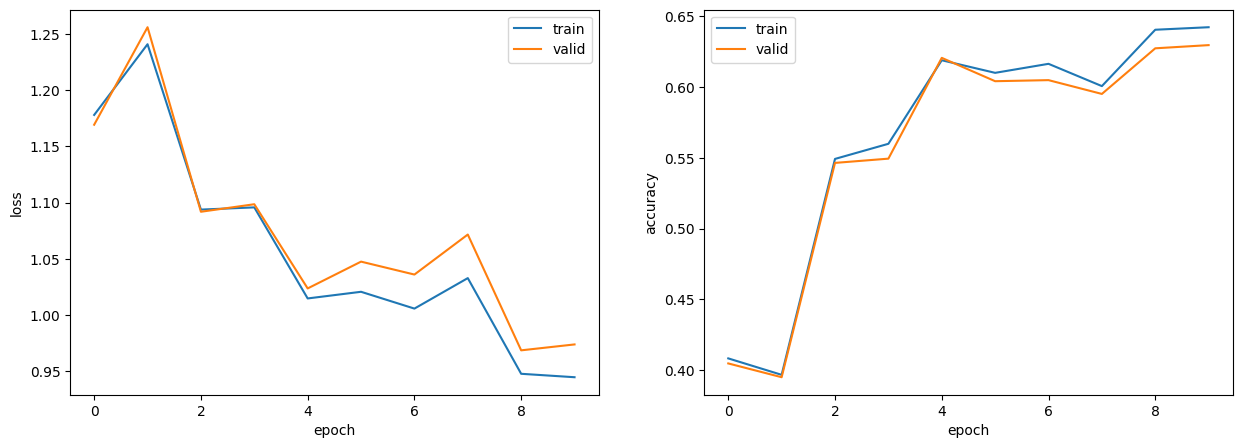

正解率（学習データ）：0.6423350824587706
正解率（評価データ）：0.6341829085457271


In [8]:
# knock84
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(id_dict.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(id_dict.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1
    if emb_weights != None:
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)
    emb = self.emb(x)
    out, hidden = self.rnn(emb, hidden)
    out = self.fc(out[:,-1,:])
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
    return hidden

# ハイパーパラメータを設定
VOCAB_SIZE = len(set(id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 0.05
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda')
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train}')
print(f'正解率（評価データ）：{acc_test}')

epoch: 1, loss_train: 1.2009, accuracy_train: 0.3974, loss_valid: 1.2043, accuracy_valid: 0.4010, 10.7236sec
epoch: 2, loss_train: 1.3737, accuracy_train: 0.3979, loss_valid: 1.4051, accuracy_valid: 0.3973, 11.1578sec
epoch: 3, loss_train: 1.0925, accuracy_train: 0.5477, loss_valid: 1.0566, accuracy_valid: 0.5697, 14.0010sec
epoch: 4, loss_train: 1.2586, accuracy_train: 0.4798, loss_valid: 1.2898, accuracy_valid: 0.4610, 9.8877sec
epoch: 5, loss_train: 1.1170, accuracy_train: 0.5346, loss_valid: 1.1214, accuracy_valid: 0.5315, 10.6707sec
epoch: 6, loss_train: 1.0603, accuracy_train: 0.5865, loss_valid: 1.0956, accuracy_valid: 0.5787, 10.6686sec
epoch: 7, loss_train: 0.9580, accuracy_train: 0.6316, loss_valid: 0.9765, accuracy_valid: 0.6229, 10.6915sec
epoch: 8, loss_train: 0.9565, accuracy_train: 0.6251, loss_valid: 0.9760, accuracy_valid: 0.6147, 10.4757sec
epoch: 9, loss_train: 0.9666, accuracy_train: 0.6213, loss_valid: 1.0014, accuracy_valid: 0.6139, 10.0742sec
epoch: 10, loss_trai

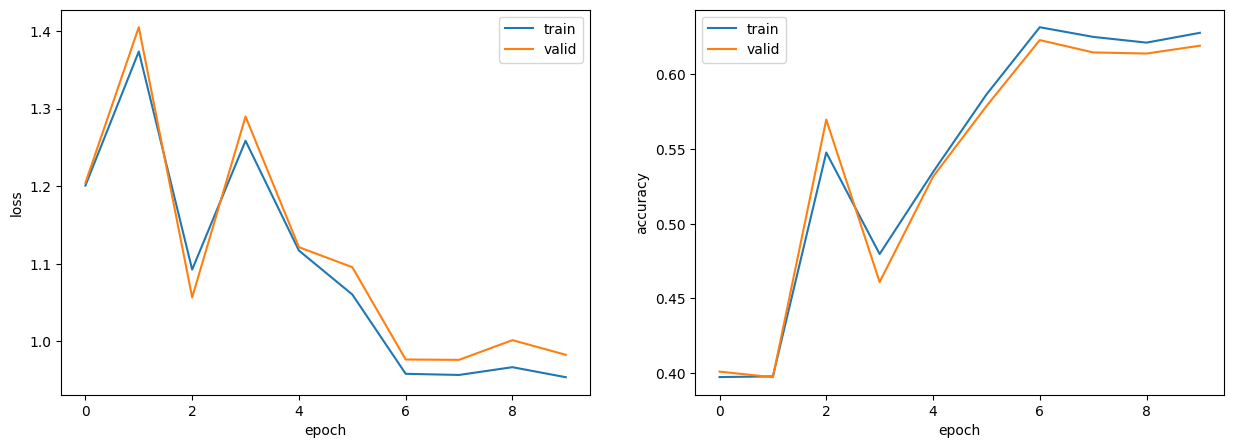

学習データの正解率 : 0.6278110944527736
評価データの正解率 : 0.6206896551724138


In [9]:
# knock85

# ハイパーパラメータを設定
VOCAB_SIZE = len(set(id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 0.05
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda')
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

visualize_logs(log)

_,acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'学習データの正解率 : {acc_train}')
print(f'評価データの正解率 : {acc_test}')

In [10]:
# knock86
from torch.nn import functional as F

class CNN(nn.Module):
  # 初期化
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None: # 埋め込み層の重みをemb_weightsで初期化する
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    # 引数は in_channels, out_channels, kernel_size, stride, padding
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    # ドロップアウト率を設定
    self.drop = nn.Dropout(0.1)
    # 全結合層
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    emb = self.emb(x).unsqueeze(1) # 埋め込み層
    conv = self.conv(emb) # 畳み込み
    act = F.relu(conv.squeeze(3)) # 活性化関数
    max_pool = F.max_pool1d(act, act.size()[2]) # 系列長方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2))) # 全結合層
    return out

# ハイパーパラメータを設定
VOCAB_SIZE = len(set(id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルを定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, weights)

# 10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2261, 0.2346, 0.2857, 0.2536]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2403, 0.2486, 0.2738, 0.2374]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2423, 0.2126, 0.2699, 0.2753]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2220, 0.2233, 0.2829, 0.2717]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2270, 0.2628, 0.2731, 0.2371]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2123, 0.2371, 0.2649, 0.2857]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2180, 0.2346, 0.2821, 0.2653]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2409, 0.2198, 0.2567, 0.2826]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2329, 0.2519, 0.2739, 0.2413]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2282, 0.2420, 0.2725, 0.2573]], grad_fn=<SoftmaxBackward0>)


epoch: 1, loss_train: 1.0883, accuracy_train: 0.5455, loss_valid: 1.0809, accuracy_valid: 0.5532, 14.1899sec
epoch: 2, loss_train: 1.0189, accuracy_train: 0.6097, loss_valid: 1.0151, accuracy_valid: 0.6162, 8.8335sec
epoch: 3, loss_train: 0.9460, accuracy_train: 0.6787, loss_valid: 0.9596, accuracy_valid: 0.6672, 9.7372sec
epoch: 4, loss_train: 0.8787, accuracy_train: 0.7023, loss_valid: 0.9048, accuracy_valid: 0.6874, 11.4910sec
epoch: 5, loss_train: 0.8303, accuracy_train: 0.7202, loss_valid: 0.8674, accuracy_valid: 0.7016, 8.7174sec
epoch: 6, loss_train: 0.7903, accuracy_train: 0.7305, loss_valid: 0.8374, accuracy_valid: 0.7114, 8.4544sec
epoch: 7, loss_train: 0.7660, accuracy_train: 0.7370, loss_valid: 0.8233, accuracy_valid: 0.7174, 9.2998sec
epoch: 8, loss_train: 0.7510, accuracy_train: 0.7432, loss_valid: 0.8141, accuracy_valid: 0.7196, 8.7619sec
epoch: 9, loss_train: 0.7446, accuracy_train: 0.7462, loss_valid: 0.8099, accuracy_valid: 0.7189, 8.4583sec
epoch: 10, loss_train: 0.7

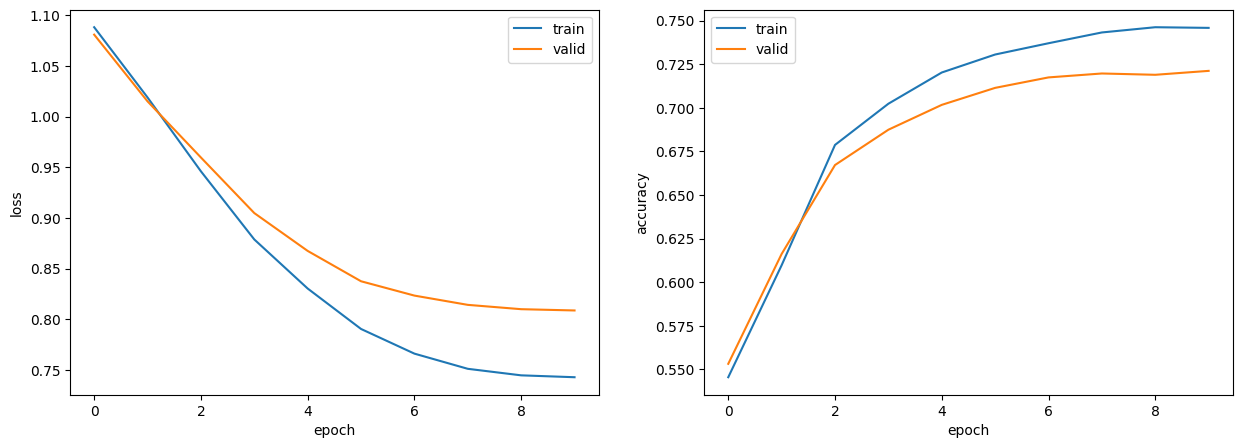

学習データの正解率 : 0.7457833583208395
評価データの正解率 : 0.7226386806596702


In [11]:
# knock87

LEARNING_RATE = 0.05
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

criterion = nn.CrossEntropyLoss() # 損失関数
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) # オプティマイザ
device = torch.device('cuda') # デバイスの指定

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

# ログを可視化
visualize_logs(log)

# 正解率
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'学習データの正解率 : {acc_train}')
print(f'評価データの正解率 : {acc_test}')

In [13]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.1 MB/s eta 0:00:00


In [31]:
# knock88
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 埋め込み層の重みをemb_weightsで初期化する
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    # Conv2dの引数は in_channels, out_channels, kernel_size, stride, padding。 層を3種類設定しているためリストにする
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    # ドロップアウト率を設定
    self.drop = nn.Dropout(drop_rate)
    # 全結合層
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)

  def forward(self, x):
    emb = self.emb(x).unsqueeze(1)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)] # 活性化関数も使う
    max_pool = [F.max_pool1d(i, i.size()[2]) for i in conv]
    max_pool_cat = torch.cat(max_pool, 1)
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    return out


import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # ハイパーパラメータを設定
  VOCAB_SIZE = len(set(id_dict.values())) + 1
  PADDING_IDX = len(set(id_dict.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]] # kernel_height, padding の組
  NUM_EPOCHS = 10

  model = textCNN(VOCAB_SIZE, emb_size, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
  device = torch.cuda.set_device(0)

  # 学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失を計算
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)

  return loss_valid


# ハイパーパラメータのチューニングを行う
study = optuna.create_study()
study.optimize(objective, timeout=7200)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))


# チューニングで得たパラメータを設定
VOCAB_SIZE = len(set(id_dict.values())) + 1
EMB_SIZE = int(trial.params['emb_size'])
PADDING_IDX = len(set(id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = int(trial.params['out_channels'])
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = trial.params['drop_rate']
LEARNING_RATE = trial.params['learning_rate']
BATCH_SIZE = int(trial.params['batch_size'])
NUM_EPOCHS = 10

model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
device = torch.cuda.set_device(0)
# 学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train}')
print(f'正解率（評価データ）：{acc_test}')

[I 2023-07-10 07:53:55,866] A new study created in memory with name: no-name-565cdce7-5a92-4bc7-a495-9c765f762ba8
<ipython-input-31-a11e8ed43542>:31: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
<ipython-input-31-a11e8ed43542>:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
<ipython-input-31-a11e8ed43542>:33: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=.

epoch: 1, loss_train: 1.1690, accuracy_train: 0.4888, loss_valid: 1.1483, accuracy_valid: 0.4970, 32.8099sec
epoch: 2, loss_train: 1.1539, accuracy_train: 0.5079, loss_valid: 1.1346, accuracy_valid: 0.5187, 33.2802sec
epoch: 3, loss_train: 1.1419, accuracy_train: 0.5092, loss_valid: 1.1259, accuracy_valid: 0.5075, 32.4408sec
epoch: 4, loss_train: 1.1311, accuracy_train: 0.5204, loss_valid: 1.1158, accuracy_valid: 0.5142, 32.7678sec
epoch: 5, loss_train: 1.1219, accuracy_train: 0.5238, loss_valid: 1.1066, accuracy_valid: 0.5517, 32.0476sec
epoch: 6, loss_train: 1.1131, accuracy_train: 0.5301, loss_valid: 1.1004, accuracy_valid: 0.5270, 37.1409sec


[W 2023-07-10 07:57:18,970] Trial 0 failed with parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.2, 'learning_rate': 0.0007585686097464897, 'momentum': 0.7, 'batch_size': 32.0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-31-a11e8ed43542>", line 51, in objective
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)
  File "<ipython-input-6-015abf4719ee>", line 63, in train_model
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 200, in backward
    Variable._execution_engine.run_backward(  # Calls int

KeyboardInterrupt: ignored

In [ ]:
# knock89

